# IRI and Road quality

> Estimate road quality and IRI (International Roughness Index) from GPS data and mobile accelerometer data (IMU)


In [ ]:
# | default_exp analysis.motion.iri

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# | export
# | hide

# basic imports
from __future__ import annotations

# sys and paths imports
import json
import logging
import os

# typing imports
from enum import Enum
from pathlib import Path
from typing import Literal

# cv and image imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv

# widgets imports
from matplotlib.ticker import PercentFormatter
from pyproj import Geod
from scipy.signal import find_peaks

from ds_contrib.core.files.structure import GSBrowserFileStructure
from ds_contrib.core.paths import (
    Directory,
    PathLike,
    pathify,
)

# visualization imports
from ds_contrib.core.utils import Iterifiable, exclusive_args, listify
from ds_contrib.tools.io.gscloud import GSBrowser

In [ ]:
# | export
# | hide

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd

In [ ]:
# | export
# | hide

logger = logging.getLogger(__name__)

In [ ]:
# | hide

CWD = Path.cwd()
REPO_DIR = Path(*CWD.parts[: CWD.parts.index("ds_contrib") + 1])
CONFIGS_DIR = REPO_DIR / "configs"
ENV_DIR = CONFIGS_DIR / "env/local"

with open(CONFIGS_DIR / "storage/gscloud/projects_vars.json") as f:
    projects = json.load(f)

# choose project
project = projects["dev"]
env_path = Path(ENV_DIR / f'{project["env"]}_roadly.env')

_ = load_dotenv(env_path)  # read local .env file
google_app_creds = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
roadly_cookie = os.getenv("ROADLY_COOKIE")
print(f"Initial configuration has finished:\nProject: {project}")


with open(CONFIGS_DIR / "storage/recslam/recslam_structure.json", "r") as f:
    RECSLAM_STRUCTURE = json.load(f)

Initial configuration has finished:
Project: {'project': 'roadly-project-dev', 'env': 'dev', 'coldline_name': 'standard'}


## Reading sensor data from recslam


In [ ]:
# | export

geod = Geod(ellps="WGS84")
g = 9.80665

Getting a list of paths from Google Cloud Storage


In [ ]:
# | export
@exclusive_args(["recslam_file_structure", "path"])
def _get_from_dfs_or_path(
    recslam_file_structure: GSBrowserFileStructure | None = None,
    path: PathLike | None = None,
    dfs_prefix: str | None = None,
) -> Path:
    if recslam_file_structure:
        if dfs_prefix is None:
            raise ValueError(
                "If recslam_file_structure is provided, dfs_prefix must be provided as well."
            )
        recslam_file_structure.get(dfs_prefix)
        path: Path = recslam_file_structure[dfs_prefix].meta["local_path"]
    else:
        path = pathify(path)
    return path


@exclusive_args(["recslam_file_structure", "path"])
def read_recslam_gps_raw(
    recslam_file_structure: GSBrowserFileStructure | None = None,
    path: PathLike | None = None,
) -> pd.DataFrame:
    path = _get_from_dfs_or_path(recslam_file_structure, path, "common/gps")
    gps_df = pd.read_csv(path)
    return gps_df


@exclusive_args(["recslam_file_structure", "path"])
def read_recslam_motion_raw(
    recslam_file_structure: GSBrowserFileStructure | None = None,
    path: PathLike | None = None,
) -> pd.DataFrame:
    path = _get_from_dfs_or_path(recslam_file_structure, path, "common/motion")
    motion_df = pd.read_csv(path)
    return motion_df


@exclusive_args(["recslam_file_structure", "path"])
def read_recslam_timestamps_raw(
    recslam_file_structure: GSBrowserFileStructure | None = None,
    path: PathLike | None = None,
    camera: Literal["wide", "ultrawide"] = "wide",
) -> dict:
    path = _get_from_dfs_or_path(
        recslam_file_structure, path, f"camera_{camera}/timestamps"
    )
    with open(path) as f:
        timestamps_json = json.load(f)
    return timestamps_json


def standardize_recslam_gps_raw(gps_df: pd.DataFrame):
    gps_df["time"] = pd.to_datetime(gps_df["time"], unit="s")
    gps_df.set_index("time", inplace=True)
    return gps_df


def standardize_recslam_motion_raw(motion_df: pd.DataFrame):
    motion_df["time"] = pd.to_datetime(motion_df["time"], unit="s")
    motion_df.set_index("time", inplace=True)
    return motion_df


def standardize_recslam_timestamps_raw(timestamps_json: dict):
    timestamps_df = pd.DataFrame(timestamps_json)
    timestamps_df["frame_number"] = timestamps_df.index
    timestamps_df["time"] = pd.to_datetime(timestamps_df["time"], unit="s")
    timestamps_df.set_index("time", inplace=True)
    return timestamps_df


def read_recslam_sensor_data_raw(
    reclsam_file_structure: GSBrowserFileStructure,
    camera: Literal["wide", "ultrawide"] = "wide",
    sensor_data: Literal["motion", "gps", "timestamps", "all"] = "all",
) -> dict[str, pd.DataFrame | dict]:
    """Reads recslam sensor data from a GSBrowserFileStructure, downloading it if necessary.

    Parameters
    ----------
    reclsam_file_structure : GSBrowserFileStructure
        A GSBrowserFileStructure object containing the recslam data.
    camera : Literal['wide', 'ultrawide'], optional
        The camera to use, by default 'wide'
    sensor_data : Literal['motion', 'gps', 'timestamps', 'all'], optional
        The sensor data to read, by default 'all'

    Returns
    -------
    dict[str, pd.DataFrame|dict]
        A dictionary containing the motion, gps and timestamps dataframes.
    """
    # load data, skip if already loaded
    raw_sensor_data = {}
    if sensor_data == "all" or sensor_data == "gps":
        gps_df = read_recslam_gps_raw(reclsam_file_structure)
        raw_sensor_data["gps_df"] = gps_df
    if sensor_data == "all" or sensor_data == "motion":
        motion_df = read_recslam_motion_raw(reclsam_file_structure)
        raw_sensor_data["motion_df"] = motion_df
    if sensor_data == "all" or sensor_data == "timestamps":
        timestamps_json = read_recslam_timestamps_raw(
            reclsam_file_structure, camera=camera
        )
        raw_sensor_data["timestamps_json"] = timestamps_json
    return raw_sensor_data


def standardize_recslam_sensor_data(
    raw_sensor_data: dict[str, pd.DataFrame | dict]
) -> dict[str, pd.DataFrame]:
    """Makes the raw sensor data consistent with each other.
    Converts all data to dataframes with DateTime index and timestamps to datetime objects.

    Parameters
    ----------
    raw_sensor_data : dict[str, pd.DataFrame|dict]
        A dictionary containing the motion, gps and timestamps dataframes optionally with corresponding names. The dict is expected to contain at least one of the following keys: 'motion_df', 'gps_df', 'timestamps_json'.
        This dict may be built using the `read_raw_recslam_sensor_data` or separately by `read_recslam_...` function.

    Returns
    -------
    dict[str, pd.DataFrame]
        A dictionary containing the motion, gps and timestamps dataframes.
    """
    # prepare raw dataframes
    standardized_data = {}
    if "motion_df" in raw_sensor_data:
        standardized_data["motion"] = standardize_recslam_motion_raw(
            raw_sensor_data["motion_df"]
        )
    if "gps_df" in raw_sensor_data:
        standardized_data["gps"] = standardize_recslam_gps_raw(
            raw_sensor_data["gps_df"]
        )

    if "timestamps_json" in raw_sensor_data:
        standardized_data["timestamps"] = standardize_recslam_timestamps_raw(
            raw_sensor_data["timestamps_json"]
        )

    return standardized_data


@exclusive_args(["dfs", "paths"], may_be_empty=False)
def read_recslam_sensor_data_standard(
    dfs: GSBrowserFileStructure | None = None, paths: dict[str, PathLike] | None = None
):
    if dfs:
        raw_sensor_data = read_recslam_sensor_data_raw(dfs)
    else:
        paths = {k: pathify(v) for k, v in paths.items()}
        raw_sensor_data = {}
        if "motion_path" in paths:
            raw_sensor_data["motion_df"] = read_recslam_motion_raw(
                path=paths["motion_path"]
            )
        if "gps_path" in paths:
            raw_sensor_data["gps_df"] = read_recslam_gps_raw(path=paths["gps_path"])
        if "timestamps_path" in paths:
            raw_sensor_data["timestamps_json"] = read_recslam_timestamps_raw(
                path=paths["timestamps_path"]
            )

    standardized_data = standardize_recslam_sensor_data(raw_sensor_data)
    return standardized_data

In [ ]:
# | hide

RECSLAM_DATA_PATH = "roadly-dev-videos/Antalya/2022-02-21_13-18-38_4453/"

Initialize downloads directory and GSBrowser object


In [ ]:
downloads_dir = Directory("downloads", temporary=True)
browser = GSBrowser(
    project=project["project"],
    credentials=google_app_creds,
    downloads_dir=downloads_dir,
)

Check that data exists


In [ ]:
# RECSLAM_DATA_PATH must be a prefix and bucket to the root of recslam data
assert browser.is_present(RECSLAM_DATA_PATH), "Data is not present"

Initialize GSBroserFileStructure object and read necessary files


In [ ]:
dfs = GSBrowserFileStructure(
    browser,
    downloads_dir,
    CONFIGS_DIR / "storage/recslam/recslam_structure.json",
    RECSLAM_DATA_PATH,
)

In [ ]:
road_quality_dfs = read_recslam_sensor_data_standard(dfs=dfs)
print(road_quality_dfs.keys())

dict_keys(['motion', 'gps', 'timestamps'])


## Mapping sensor data to shared index


In [ ]:
# | export
# | hide


def _get_dist(df):
    # Helper function to compute distance between two GPS coordinates
    _, _, dist = geod.inv(df["lon"], df["lat"], df["lon"].shift(), df["lat"].shift())
    return dist

In [ ]:
# | export


def get_shared_time_index(dataframes: list[pd.DataFrame]):
    """Get shared time index for a list of dataframes

    Dataframes may have different time indexes with different frequencies or may be aperiodic,
    this function returns a shared time index for all dataframes starting from the earliest timestamp
    and ending at the latest timestamp with the minimum frequency of all dataframes.

    Parameters
    ----------
    dataframes : list[pd.DataFrame]
        list of dataframes with DatetimeIndex

    Returns
    -------
    pd.DatetimeIndex
        shared time index for the list of dataframes
    """
    assert all(
        [isinstance(df.index, pd.DatetimeIndex) for df in dataframes]
    ), f"Dataframes must have a DatetimeIndex"
    start_timestamp = min([df.index.min() for df in dataframes])
    end_timestamp = max([df.index.max() for df in dataframes])
    min_delta = min(
        [df.index.to_series().diff().dt.total_seconds().mean() for df in dataframes]
    )
    ms_min_delta: int = round(min_delta * 1000)  # convert to milliseconds
    shared_time_index = pd.date_range(
        start=start_timestamp, end=end_timestamp, freq=f"{ms_min_delta}L"
    )
    return shared_time_index


def map_df_to_shared_index(
    df: pd.Series | pd.DataFrame,
    shared_time_index: pd.DatetimeIndex | pd.DataFrame | pd.Series,
    direction: Literal["nearest", "backward", "forward"] = "nearest",
    column_suffix=None,
):
    """Map a dataframe with DateTime index to a shared time index

    It is possible that the dataframe has a different time index than the shared time index,
    this function maps the dataframe to the shared time index using the specified direction.

    All timestamps in the shared time index will be present in the resulting dataframe,
    and every original point will be mapped to the nearest point in the shared time index.
    For convenience, points from the original dataframe will be marked as "original" in the
    resulting dataframe, and points that were interpolated will be marked as "interpolated"/"extrapolated".

    Parameters
    ----------
    df : pd.Series | pd.DataFrame
        dataframe with DatetimeIndex
    shared_time_index : pd.DatetimeIndex | pd.DataFrame | pd.Series
        shared time index to map the dataframe to
    direction : Literal[&quot;nearest&quot;, &quot;backward&quot;, &quot;forward&quot;], optional
        direction to map the dataframe to the shared time index, by default &quot;nearest&quot;
    column_suffix : _type_, optional
        which suffix to append to `original_time` and `source` columns in the resulting dataframe, by default None

    Returns
    -------
    pd.DataFrame
        dataframe with shared time index and `original_time` and `source` columns

    Raises
    ------
    TypeError
        if `shared_time_index` is not pd.DatetimeIndex, pd.Series or pd.DataFrame
    TypeError
        if `df` is not pd.Series or pd.DataFrame
    """
    if isinstance(shared_time_index, (pd.DatetimeIndex, pd.Series)):
        shared_time_index = pd.DataFrame(index=shared_time_index)
        shared_time_index.index.name = "timestamp"
    else:
        if not isinstance(shared_time_index, pd.DataFrame):
            raise TypeError(
                f"`shared_time_index` should be pd.DatetimeIndex, pd.Series or pd.DataFrame, but got `{type(shared_time_index)}`"
            )
    if isinstance(df, pd.Series):
        df = df.to_frame()
    else:
        if not isinstance(df, pd.DataFrame):
            raise TypeError(
                f"`df` should be pd.Series or pd.DataFrame, but got {type(df)}"
            )
        df = df.copy()
    original_time_str = (
        "original_time" if column_suffix is None else f"original_time_{column_suffix}"
    )
    source_str = "source" if column_suffix is None else f"source_{column_suffix}"
    df[original_time_str] = df.index.to_series()

    result_df = pd.merge_asof(
        shared_time_index,
        right=df,
        left_index=True,
        right_index=True,
        tolerance=pd.Timedelta(shared_time_index.index.freq / 2),
        direction=direction,
    )
    # add interpolation status
    interpolation_slice = slice(
        result_df[original_time_str].min(), result_df[original_time_str].max()
    )
    result_df.loc[interpolation_slice, source_str] = "interpolated"
    result_df.loc[result_df[original_time_str].notna(), source_str] = "original"
    result_df.loc[result_df[source_str].isna(), source_str] = "extrapolated"
    return result_df


def interpolate_inner(
    df: pd.DataFrame, column: str, method: str, limit_direction: str
) -> pd.DataFrame:
    """Interpolate a column in a dataframe inplace, but filling only values between the first and last non-null values

    Parameters
    ----------
    df : pd.DataFrame
        dataframe to interpolate
    column : str
        column to interpolate
    method : str
        interpolation method, see `pandas.DataFrame.interpolate`
    limit_direction : str
        limit direction, see `pandas.DataFrame.interpolate`

    Returns
    -------
    pd.DataFrame
        dataframe with interpolated column
    """
    first_non_null = df[column].first_valid_index()
    last_non_null = df[column].last_valid_index()
    selected_rows = slice(first_non_null, last_non_null)
    df.loc[selected_rows, column] = df.loc[selected_rows, column].interpolate(
        method=method, limit_direction=limit_direction
    )
    return df


def get_path_from_gps(pd_gps: pd.DataFrame, shared_time_index) -> gpd.GeoDataFrame:
    """Convert GPS data to a GeoDataFrame with a shared time index,
    also computes the cumulative distance - `path` for each GPS data point and `path_progress` (from 0 to 1)

    Parameters
    ----------
    pd_gps : pd.DataFrame
        dataframe with GPS data, must have a DatetimeIndex
    shared_time_index : pd.DatetimeIndex
        shared time index to map the dataframe to

    Returns
    -------
    gpd.GeoDataFrame
        GeoDataFrame with shared time index and `path` and `path_progress` columns,
        lon, lat and altitude columns are interpolated to the shared time index and converted to a geometry column
    """
    # Compute distance and cumulative distance for each GPS data point
    pd_gps["dist_delta"] = _get_dist(pd_gps).astype(pd.Float32Dtype)
    pd_gps["dist_delta"].fillna(0, inplace=True)
    pd_gps["path"] = pd_gps["dist_delta"].cumsum()

    # Interpolate the GPS time and total distance data
    mapped_gps = map_df_to_shared_index(
        pd_gps[["path", "lon", "lat", "altitude"]],
        shared_time_index,
        column_suffix="gps",
    )
    interpolate_inner(mapped_gps, "path", "linear", "both")
    interpolate_inner(mapped_gps, "lon", "linear", "both")
    interpolate_inner(mapped_gps, "lat", "linear", "both")
    interpolate_inner(mapped_gps, "altitude", "linear", "both")
    # TODO[High](Buggy): check crs
    mapped_gps["gps"] = gpd.points_from_xy(
        mapped_gps["lon"], mapped_gps["lat"], mapped_gps["altitude"], crs="EPSG:4326"
    )
    mapped_gps.drop(columns=["lon", "lat", "altitude"], inplace=True)
    mapped_gps["path_progress"] = mapped_gps["path"] / mapped_gps["path"].max()
    return gpd.GeoDataFrame(mapped_gps, geometry="gps")

In [ ]:
# | export


def get_shared_index_for_sensor_data(
    pd_gps: pd.DataFrame, pd_timestamps: pd.DataFrame, pd_motion: pd.DataFrame
) -> pd.DataFrame:
    """Get a shared index for all sensor data, including GPS, timestamps and motion data.
    All the dataframes will be interpolated to the shared index with frequency of the motion data (10ms).
    WARNING: this function generates index, therefore it does not include the whole data from original dataframes,
        only data usefull for indexing, interpolation and slicing

    Additional info attached to all the dataframes:
    - `original_time_{suffix}` - original timestamp from the corresponding dataframe
    - `source_{suffix}` - whether the point was interpolated or extrapolated
    - `path` - cumulative distance from the start of the path
    - `path_progress` - cumulative distance from the start of the path normalized to [0, 1]
    - `frame_number` - frame number from the camera timestamps

    Parameters
    ----------
    pd_gps : pd.DataFrame
        original GPS dataframe
    pd_timestamps : pd.DataFrame
        original timestamps dataframe
    pd_motion : pd.DataFrame
        original motion dataframe

    Returns
    -------
    pd.DataFrame
        shared index dataframe
    """
    # get shared timestamps index, which is the intersection of all timestamps with the smallest delta
    shared_time_index = get_shared_time_index([pd_timestamps, pd_gps, pd_motion])
    # map timestamps to shared index
    shared_index_frames = map_df_to_shared_index(
        pd_timestamps["frame_number"], shared_time_index, column_suffix="frames"
    )
    # map gps to shared index
    shared_index_gps = get_path_from_gps(pd_gps, shared_time_index)
    # compose shared index from frames and gps
    shared_index = shared_index_frames.merge(
        shared_index_gps, left_index=True, right_index=True
    )
    shared_index = interpolate_inner(shared_index, "frame_number", "nearest", "both")
    return gpd.GeoDataFrame(shared_index, geometry="gps")

#### Examine raw data


In [ ]:
road_quality_dfs["gps"].head(2)

,lat,lon,accuracy,altitude,altitude_accuracy,course,speed
time,,,,,,,
2022-02-21 10:18:39.294273024,55.7517,48.80356,10.0,0.2,19.0,308.0,0.0
2022-02-21 10:18:40.294312960,55.7517,48.80356,10.0,0.2,19.0,308.0,0.0


In [ ]:
road_quality_dfs["motion"].head(2)

,yaw,roll,pitch,rrate_x,rrate_y,rrate_z,gravity_x,gravity_y,gravity_z,accel_x,accel_y,accel_z,magnetic_x,magnetic_y,magnetic_z,date
time,,,,,,,,,,,,,,,,
2022-02-21 10:18:38.396164864,-3.125586,1.638006,0.017120,0.009375,0.012892,0.002015,0.997596,-0.017119,0.067149,-0.015159,-0.005906,0.006062,0.0,0.0,0.0,1.645439e+09
2022-02-21 10:18:38.406178048,-3.125475,1.638064,0.017198,-0.033994,-0.010120,0.007395,0.997591,-0.017197,0.067208,0.006758,-0.011475,0.016945,0.0,0.0,0.0,1.645439e+09


In [ ]:
road_quality_dfs["timestamps"].head(2)

,exp,iso,brightness,frame_number
time,,,,
2022-02-21 10:18:38.516,0.00039,50,9.92124,0
2022-02-21 10:18:38.716,0.00039,50,9.92124,1


#### Lets create a common index


In [ ]:
shared_index = get_shared_index_for_sensor_data(
    road_quality_dfs["gps"], road_quality_dfs["timestamps"], road_quality_dfs["motion"]
)

We see here, that our data is not sampled at the same rate. We will need to interpolate the data to a common index. GPS data sampled at 1Hz, IMU data sampled at 100Hz and frames at 5Hz. Therefore `original_time` is always does not have a common index. We see here that some of `source` data has `original` value, that means the data is not interpolated but mapped to a nearest index.


In [ ]:
shared_index[18090:18094]

,frame_number,original_time_frames,source_frames,path,original_time_gps,source_gps,gps,path_progress
timestamp,,,,,,,,
2022-02-21 10:21:39.296164864,904.0,NaT,interpolated,3377.268717,2022-02-21 10:21:39.296699904,original,POINT Z (48.83943 55.77301 0.10000),0.933837
2022-02-21 10:21:39.306164864,904.0,2022-02-21 10:21:39.306999808,original,3377.351901,NaT,interpolated,POINT Z (48.83943 55.77301 0.10000),0.933860
2022-02-21 10:21:39.316164864,904.0,NaT,interpolated,3377.435085,NaT,interpolated,POINT Z (48.83943 55.77301 0.10000),0.933883
2022-02-21 10:21:39.326164864,904.0,NaT,interpolated,3377.518270,NaT,interpolated,POINT Z (48.83943 55.77301 0.10000),0.933906


We also see that index may be wider then the specific data source, e.g, for `gps` at first timestamps we have no data, and therefore it is indicated as `source` `extrapolated`.


In [ ]:
shared_index.head(3)

,frame_number,original_time_frames,source_frames,path,original_time_gps,source_gps,gps,path_progress
timestamp,,,,,,,,
2022-02-21 10:18:38.396164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN
2022-02-21 10:18:38.406164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN
2022-02-21 10:18:38.416164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN


In [ ]:
# | export
def get_road_qaulity_agg_func(
    shared_index: pd.DataFrame,
    index: Literal[
        "timestamp", "path_progress", "frame_number", "gps"
    ] = "frame_number",
):
    # Depends: Depends on `road_quality_from_sensor_data` function and columns it creates
    def _get_source_agg_func(names: Iterifiable[str]):
        names: list[str] = listify(names)
        d = {}
        for name in names:
            d[
                f"original_time_{name}"
            ] = lambda x: x.dropna().mean()  # if x.dropna().values.size > 0 else pd.NaT
            d[f"source_{name}"] = (
                lambda x: "original" if "original" in x.values else x.mode().iloc[0]
            )
        return d

    road_quality_agg_func = {
        "frame_number": "median",
        "timestamp": "mean",
        "path": "mean",
        "gps": lambda x: x.unary_union.centroid if x.geometry.unary_union else None,
        "path_progress": "mean",
        "accel_x": lambda x: x.iloc[x.abs().to_numpy().argmax()],
        "section_number": "median",
        "rms": "mean",
        "iri": "mean",
        "rolling_accel_x": "mean",
        "ride_quality": "mean",
        "anomalies": "max",
        "bump": "any",
    }
    road_quality_agg_func.update(_get_source_agg_func(["gps", "frames", "imu"]))
    columns = [shared_index.index.name, *shared_index.columns.to_list()]
    road_quality_agg_func = {
        c: road_quality_agg_func[c] for c in columns if not c == index
    }
    return road_quality_agg_func


def change_index(shared_index_df: pd.DataFrame, new_index: str, agg_func=None):
    """Utility method to change the index of a dataframe inplace
        and create a named column from the old index

    Parameters
    ----------
    shared_index_df : pd.DataFrame
        shared index dataframe
    new_index : str
        new index name from the columns of the dataframe

    Returns
    -------
    pd.DataFrame
        shared index dataframe with new index
    """
    if shared_index_df.index.name == new_index:
        return shared_index_df
    assert new_index in shared_index_df.columns, f"Index {new_index} is not in columns"
    shared_index_df = shared_index_df.reset_index(names=[shared_index_df.index.name])
    shared_index_df.set_index(new_index, inplace=True)
    if agg_func:
        shared_index_df = shared_index_df.groupby(new_index).agg(agg_func)
    return shared_index_df

In [ ]:
# |code-fold: true

frame_number_shared_index = change_index(
    shared_index,
    "frame_number",
    get_road_qaulity_agg_func(shared_index, "frame_number"),
)

In [ ]:
frame_number_shared_index

,timestamp,original_time_frames,source_frames,path,original_time_gps,source_gps,gps,path_progress
frame_number,,,,,,,,
0.0,2022-02-21 10:18:38.566164736,2022-02-21 10:18:38.516000000,original,NaN,NaT,extrapolated,None,NaN
1.0,2022-02-21 10:18:38.721164800,2022-02-21 10:18:38.716000000,original,NaN,NaT,extrapolated,None,NaN
2.0,2022-02-21 10:18:38.921164800,2022-02-21 10:18:38.915000064,original,NaN,NaT,extrapolated,None,NaN
3.0,2022-02-21 10:18:39.121164800,2022-02-21 10:18:39.116000000,original,NaN,NaT,extrapolated,None,NaN
4.0,2022-02-21 10:18:39.321164800,2022-02-21 10:18:39.316000000,original,0.000000,2022-02-21 10:18:39.294273024,original,POINT (48.80356 55.75170),0.0
...,...,...,...,...,...,...,...,...
1523.0,2022-02-21 10:23:43.121164800,2022-02-21 10:23:43.116000000,original,3616.551048,NaT,interpolated,POINT (48.83665 55.77394),1.0
1524.0,2022-02-21 10:23:43.321164800,2022-02-21 10:23:43.316000000,original,3616.551048,NaT,interpolated,POINT (48.83665 55.77394),1.0
1525.0,2022-02-21 10:23:43.521164800,2022-02-21 10:23:43.516000000,original,3616.551048,NaT,interpolated,POINT (48.83665 55.77394),1.0


## Estimate road quality


In [ ]:
# | export


class RideQuality(Enum):
    POOR = 1
    BAD = 2
    FAIR = 3
    GOOD = 4


def get_ride_quality(iri):
    if iri < 4:
        return RideQuality.GOOD.value
    elif iri >= 4 and iri < 8:
        return RideQuality.FAIR.value
    elif iri >= 8 and iri < 12:
        return RideQuality.BAD.value
    elif iri >= 12:
        return RideQuality.POOR.value


def _split_path_on_sections(path: pd.Series, section_len=100):
    return (path[path < path.max()] // section_len).astype(int)


def split_imu_on_sections(
    pd_motion: pd.DataFrame,
    shared_index: pd.DatetimeIndex,
    section_len: float = 100,
) -> pd.DataFrame:
    pd_motion = map_df_to_shared_index(pd_motion, shared_index, column_suffix="imu")
    pd_motion["section_number"] = _split_path_on_sections(pd_motion["path"])
    return pd_motion


def calculate_rms_on_sections(pd_motion_with_sections: pd.DataFrame):
    return pd_motion_with_sections.groupby("section_number", dropna=True).agg(
        rms=pd.NamedAgg(
            column="accel_x", aggfunc=lambda x: np.sqrt(np.mean(np.square(g * x)))
        )
    )


def calculate_iri(rms: pd.DataFrame):
    iri = 4.19 * rms + 1.73
    return iri


def find_bumps(pd_motion, window_size=45, height=0.8):
    bumps_df: pd.DataFrame = pd_motion.loc[:, "accel_x"].to_frame()
    bumps_df["rolling_accel_x"] = bumps_df["accel_x"].rolling(window=window_size).mean()
    bumps_df["anomalies"] = (bumps_df["rolling_accel_x"] - bumps_df["accel_x"]) ** 2
    bumps_df["bump"] = False
    peak_indices, _ = find_peaks(bumps_df["anomalies"], height=height)
    bumps_df.iloc[peak_indices, -1] = True
    bumps_df.drop(columns=["accel_x"], inplace=True)
    return bumps_df


def calculate_road_quality(shared_index: pd.DataFrame, pd_motion: pd.DataFrame):
    """Calculate road quality from motion data and maps them to shared index

    Parameters
    ----------
    shared_index : pd.DataFrame
        shared index dataframe
    pd_motion : pd.DataFrame
        original motion dataframe

    Returns
    -------
    pd.DataFrame
        shared index dataframe with road quality data
    """
    pd_motion_with_sections = split_imu_on_sections(pd_motion["accel_x"], shared_index)
    rms = calculate_rms_on_sections(pd_motion_with_sections)
    road_quality_data = pd_motion_with_sections.merge(
        rms, left_on="section_number", right_index=True, how="left"
    )
    # add iri
    road_quality_data["iri"] = road_quality_data["rms"].apply(calculate_iri)
    # add ride quality
    road_quality_data["ride_quality"] = road_quality_data["iri"].apply(get_ride_quality)

    # add bumps and anomalies
    bumps_df = find_bumps(pd_motion, height=0.3)

    road_quality_data = road_quality_data.merge(
        bumps_df, left_on="original_time_imu", right_index=True, how="left"
    )
    return road_quality_data


def road_quality_from_sensor_data(
    sensor_data_df_dict: dict[str, pd.DataFrame],
    shared_index: pd.DataFrame | None = None,
) -> pd.DataFrame:
    """Calculate road quality from sensor data

    Parameters
    ----------
    sensor_data_df_dict : dict
        dictionary with motion, gps and timestamps dataframes
    shared_index : pd.DataFrame | None, optional
        shared index dataframe if previously calculated, by default None

    Returns
    -------
    pd.DataFrame
        shared index dataframe with road quality data
    """
    # get_shared_index
    if shared_index is None:
        shared_index = get_shared_index_for_sensor_data(
            sensor_data_df_dict["gps"],
            sensor_data_df_dict["timestamps"],
            sensor_data_df_dict["motion"],
        )

    # calculate road_quality
    road_quality_data = calculate_road_quality(
        shared_index, sensor_data_df_dict["motion"]
    )
    return road_quality_data

In [ ]:
# |code-fold: true

road_quality_df = road_quality_from_sensor_data(road_quality_dfs)
road_quality_df

,frame_number,original_time_frames,source_frames,path,original_time_gps,source_gps,gps,path_progress,accel_x,original_time_imu,source_imu,section_number,rms,iri,ride_quality,rolling_accel_x,anomalies,bump
timestamp,,,,,,,,,,,,,,,,,,
2022-02-21 10:18:38.396164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.015159,2022-02-21 10:18:38.396164864,original,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-02-21 10:18:38.406164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,0.006758,2022-02-21 10:18:38.406178048,original,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-02-21 10:18:38.416164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,0.010176,2022-02-21 10:18:38.416190976,original,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-02-21 10:18:38.426164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.008173,2022-02-21 10:18:38.426204928,original,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-02-21 10:18:38.436164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.015287,2022-02-21 10:18:38.436218112,original,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-21 10:23:44.216164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.009866,2022-02-21 10:23:44.216288000,original,NaN,NaN,NaN,NaN,-0.003645,3.870554e-05,False
2022-02-21 10:23:44.226164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,-0.004722,2022-02-21 10:23:44.226304000,original,NaN,NaN,NaN,NaN,-0.003719,1.006187e-06,False
2022-02-21 10:23:44.236164864,NaN,NaT,extrapolated,NaN,NaT,extrapolated,POINT EMPTY,NaN,0.000012,2022-02-21 10:23:44.236320000,original,NaN,NaN,NaN,NaN,-0.003594,1.300420e-05,False


In [ ]:
# | export


def plot_road_quality_stats(road_quality_df: pd.DataFrame):
    """Plots the road quality overall stats for the whole dataframe

    Parameters
    ----------
    road_quality_df : pd.DataFrame
        road quality dataframe, calculated with `road_quality_from_sensor_data` function
    """
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20, 7))
    road_quality_df["iri"].plot(ax=axs[0, 0], title="iri[time]")
    change_index(road_quality_df, "path")["iri"].plot(
        ax=axs[0, 1], title="iri[distance]"
    )
    road_quality_by_frame = change_index(road_quality_df, "frame_number")

    road_quality_by_frame["iri"].plot(ax=axs[1, 0], title="iri[frame_number]")
    road_quality_by_frame["ride_quality"].plot(
        ax=axs[1, 1], ylim=(0, 5), title="ride_quality"
    )
    road_quality_by_frame["anomalies"].plot(ax=axs[2, 0], title="anomalies")
    (road_quality_by_frame["bump"] * 1).plot(ax=axs[2, 1], title="bumps")
    plt.tight_layout()
    plt.show()


def _default_plot_setup(ax, range, current_index):
    ax.grid(True)
    ax.set_xlim(range.start, range.stop)
    ax.axvline(x=current_index, color="r", linestyle="--")


def _plot_iri(ax, road_quality, range, current_index, max_val):
    road_quality["iri"].plot(ax=ax, title="iri")
    ax.set_ylim(0, max_val)
    _default_plot_setup(ax, range, current_index)


def _plot_anomalies(ax, road_quality, range, current_index, max_val=None):
    max_val = road_quality["anomalies"].max() if max_val is None else max_val
    road_quality["anomalies"].groupby("frame_number").max().plot(ax=ax)
    (road_quality["bump"] * max_val).plot(ax=ax, title="anomalies")
    ax.legend(["anomalies", "bumps"])
    ax.set_ylim(0, max_val)
    _default_plot_setup(ax, range, current_index)


def _plot_path_progress(ax, road_quality, range, current_index):
    road_quality["path_progress"].plot(title="path_progress", ax=ax)
    _default_plot_setup(ax, range, current_index)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.axhline(
        y=road_quality.loc[current_index]["path_progress"].mean(),
        color="r",
        linestyle="--",
    )


def plot_road_quality_on_range(
    road_quality_df: pd.DataFrame, range: slice, current_index=0
):
    """Plots the road quality data on a given range with a vertical line at the current index

    Parameters
    ----------
    road_quality_df : pd.DataFrame
        road quality dataframe, calculated with `road_quality_from_sensor_data` function
    range : slice
        range of frames to plot
    current_index : int, optional
        current index, by default 0
    """
    assert range.start <= current_index and (
        range.stop is None or current_index < range.stop
    ), f"Current index {current_index} is not in range {range}"
    if road_quality_df.index.name != "frame_number":
        road_quality_df = change_index(road_quality_df, "frame_number")
    max_val_anomaly = road_quality_df["anomalies"].max()
    max_val_iri = road_quality_df["iri"].max()
    road_quality_df = road_quality_df.loc[
        range.start : (None if range.stop is None else range.stop - 1)
    ]  # -1 because loc operator is inclusive
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 3))
    _plot_iri(axs[0], road_quality_df, range, current_index, max_val_iri)
    _plot_anomalies(axs[1], road_quality_df, range, current_index, max_val_anomaly)
    _plot_path_progress(axs[2], road_quality_df, range, current_index)
    plt.tight_layout()
    plt.show()

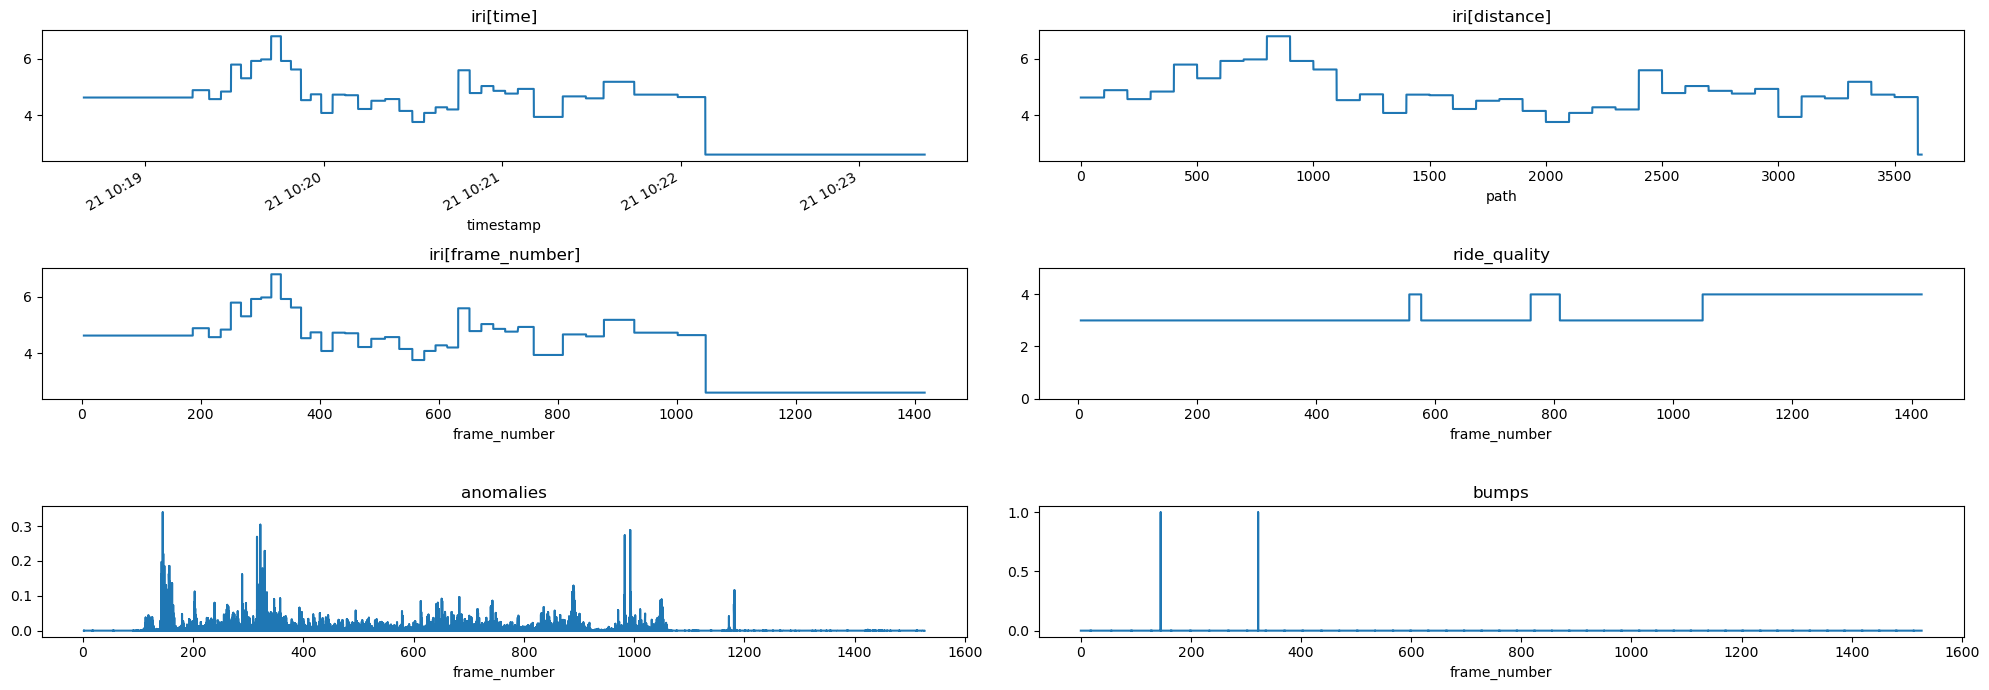

In [ ]:
plot_road_quality_stats(road_quality_df)

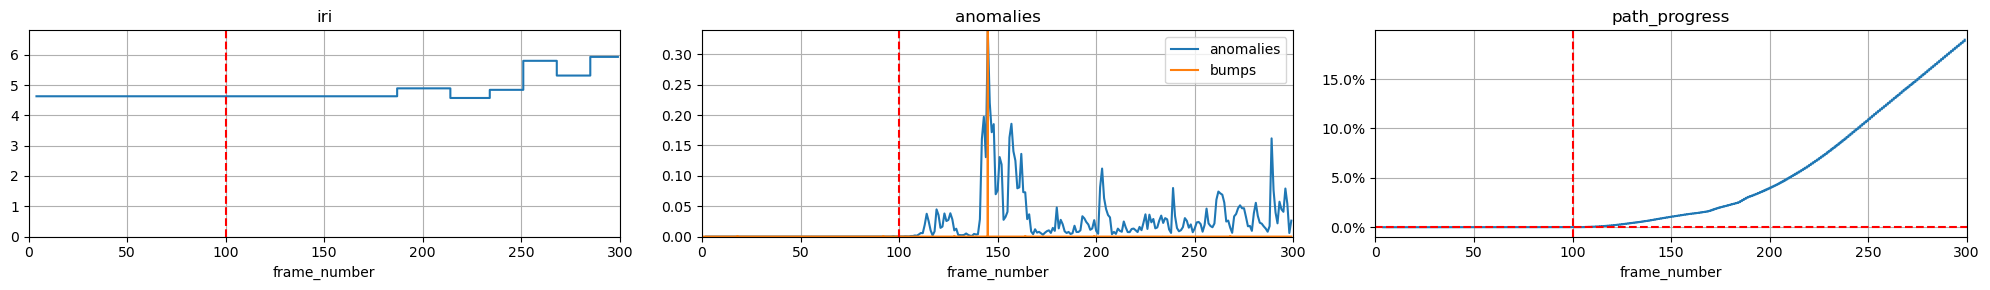

In [ ]:
plot_road_quality_on_range(road_quality_df, slice(0, 300), 100)

## Single cell example


```python
# Init download dir and GSBrowser
downloads_dir = Directory("downloads", temporary=True)
browser = GSBrowser(
    project=project["project"],
    credentials=google_app_creds,
    downloads_dir=downloads_dir,
)

# Check that data exists
# RECSLAM_DATA_PATH must be a prefix and bucket to the root of recslam data
assert browser.is_present(RECSLAM_DATA_PATH), "Data is not present"

# Initialize GSBrowserFileStructure object and read necessary files
dfs = GSBrowserFileStructure(
    browser,
    downloads_dir,
    CONFIGS_DIR / "storage/recslam/recslam_structure.json",
    RECSLAM_DATA_PATH,
)

# Read data
raw_data = read_recslam_sensor_data(dfs)
road_quality_dfs = standardize_raw_sensor_data(**raw_data)

# Calculate road quality
road_quality_data = road_quality_from_sensor_data(road_quality_dfs)

# Plot if necessary
plot_road_quality_stats(road_quality_data)
plot_road_quality_on_range(road_quality_data, slice(200, 400), 300)
```
